**Setup** <br> In this part the important packages and the data is going to be imported. The data is going to be preprocessed, so we are able to work with it.

In [90]:
# importing all the necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.neural_network import MLPRegressor # neural network that is going to be used
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
from PIL import Image

In [2]:
# importing the data and splitting it to work with
# important!! use index_col=0 to read df otherwise pca starts at col 58
ped = pd.read_csv("data_clean_with_dummies.csv", index_col=0)

# beginning of the code, so everyone has the same
np.random.seed(1) # Set the random seed for reproduceability

# Define a new X with the squared feature k = 0.99, 57+46
X = np.array(ped[ped.columns[57:103]])

# Output to predict
y = ped["pedestrians count"]

# Split the dataset into train and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.3, random_state=72)

**Hyperparameter tuning** <br> The different hyperparameters of the used function for our neural netwwork (MLPRegressor by sklearn) are being optimized. <br> 1. Establish a base scenario with the standard parameters to compare afterwards. <br> 2. Have a look at the base scenarion in a plot <br> 3. Analyze the influence of the different parameters of MLPRegressor <br> 4. Trying to find the best parameters using GridSearchCV

In [3]:
# initialize a neural network with the standard parameters 
nnet_base = MLPRegressor()

In [4]:
# scale the data to work so it is less sensitive to feature scaling 
scaler = StandardScaler()
# scale the inputs
scaler.fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
# apply the same transformation to the test data to have meaningful results
Xtest = scaler.transform(Xtest)
# scale the y different because we can't use standardscaler to a 1d array
mu, sigma = y.mean(), y.std() # We will use this to scale back to original values!
ytest = (ytest - mu) / sigma
ytrain = (ytrain - mu) /sigma

In [5]:
# Fit the network to the train data
nnet_base.fit(Xtrain, ytrain)

# Make predictions
ypred_train = nnet_base.predict(Xtrain)
ypred = nnet_base.predict(Xtest)

# Reconstruct outputs and scale predictions
ytest = ytest * sigma + mu
ytrain = ytrain * sigma + mu
ypred_train = ypred_train * sigma + mu
ypred = ypred * sigma + mu

# Compute the MAE
mae_train = mean_absolute_error(ytrain, ypred_train)
mae_test = mean_absolute_error(ytest, ypred)
# Comute R^2
r2_train = r2_score(ytrain, ypred_train)
r2_test = r2_score(ytest, ypred)

print(f"The mean absolute error of the training data is {mae_train:>10.2f}")
print(f"The R^2 of the training data is {r2_train:>10.2f}")
print(20 * "*")
print(f"The mean absolute error of the testing data is {mae_test:>10.2f}")
print(f"The R^2 of the testing data is {r2_test:>10.2f}")

The mean absolute error of the training data is     347.45
The R^2 of the training data is       0.96
********************
The mean absolute error of the testing data is     473.78
The R^2 of the testing data is       0.94


*Results:* <br> The mean absolute error of the training data is 347.45 <br>
The R^2 of the training data is 0.96 <br>
******************** <br>
The mean absolute error of the testing data is 473.78 <br>
The R^2 of the testing data is 0.94

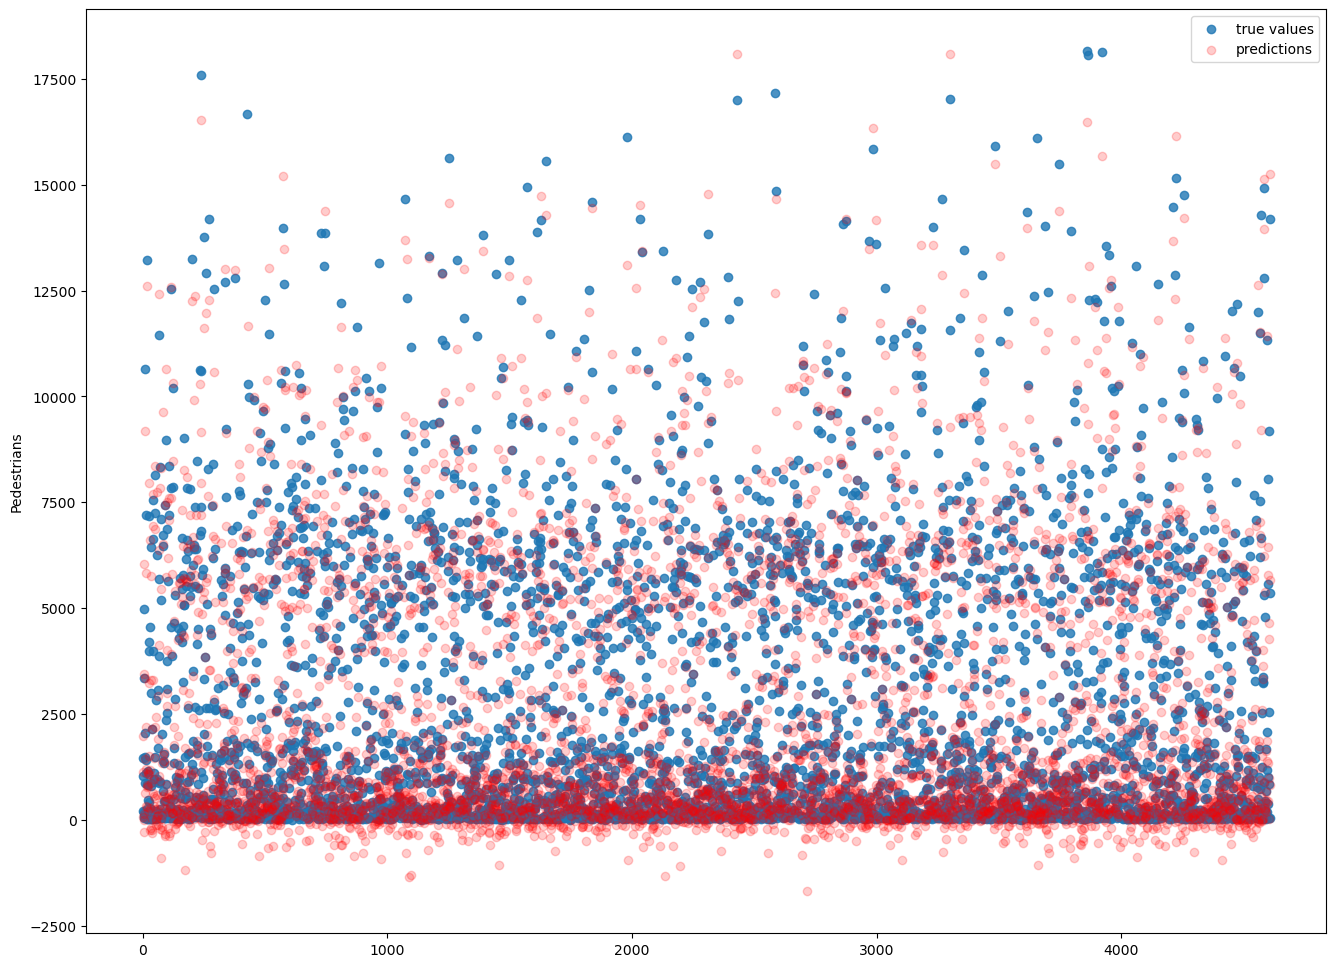

In [6]:
# plot the results to see the results of our base scenario
fig, ax = plt.subplots(figsize=(16, 12))

#create a linspace to match the y-values
xs = np.linspace(0, ytest.shape[0], num=ytest.shape[0])

# plot the true values for 2 pca variables
ax.scatter(xs, ytest, label="true values", alpha=0.8)

# plot the predictions
ax.scatter(xs, ypred, label="predictions", color = "red", alpha=0.2)

# Add labels and legend
ax.set_ylabel("Pedestrians")
ax.legend()

**Why is our model predicting negative values?** <br> If we use MLP Regressor we can't define an activation function for our output layer. Due to this fact our model is prediction negative values even if it doesn't make any sense.

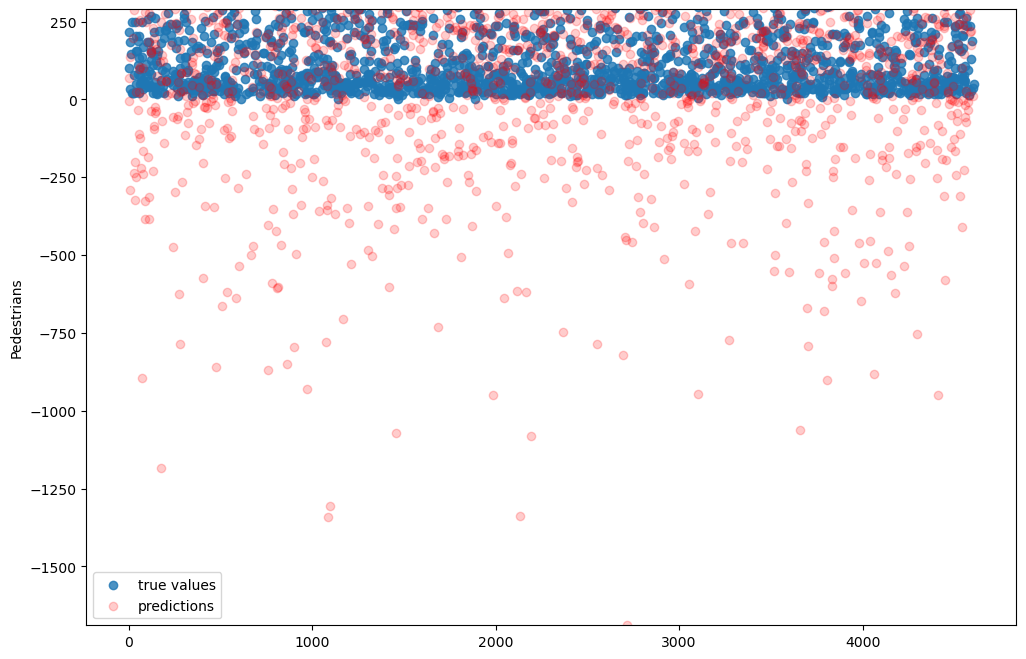

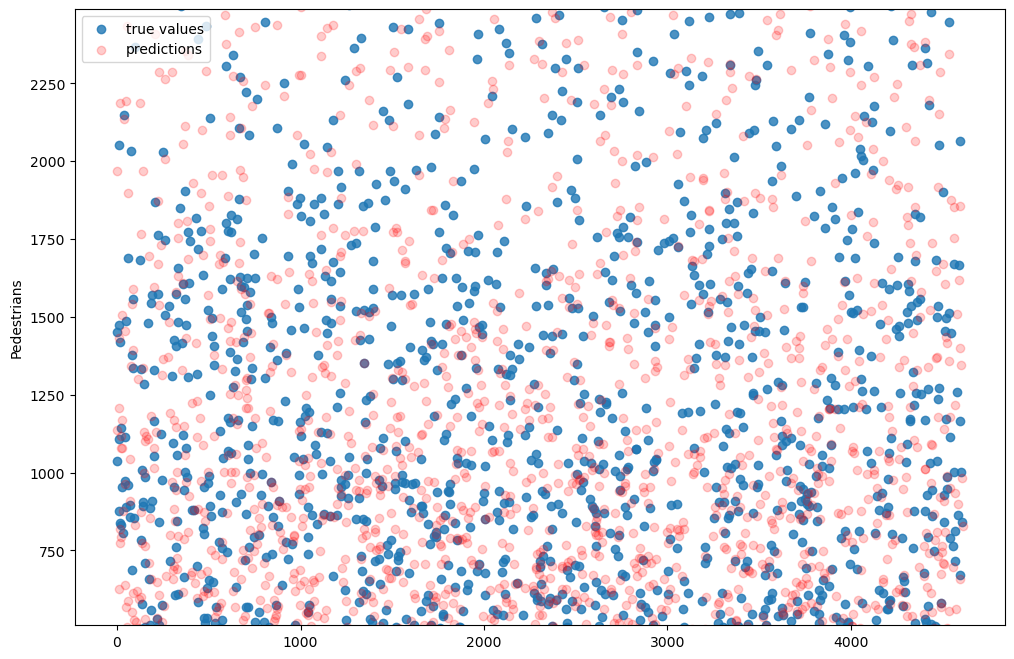

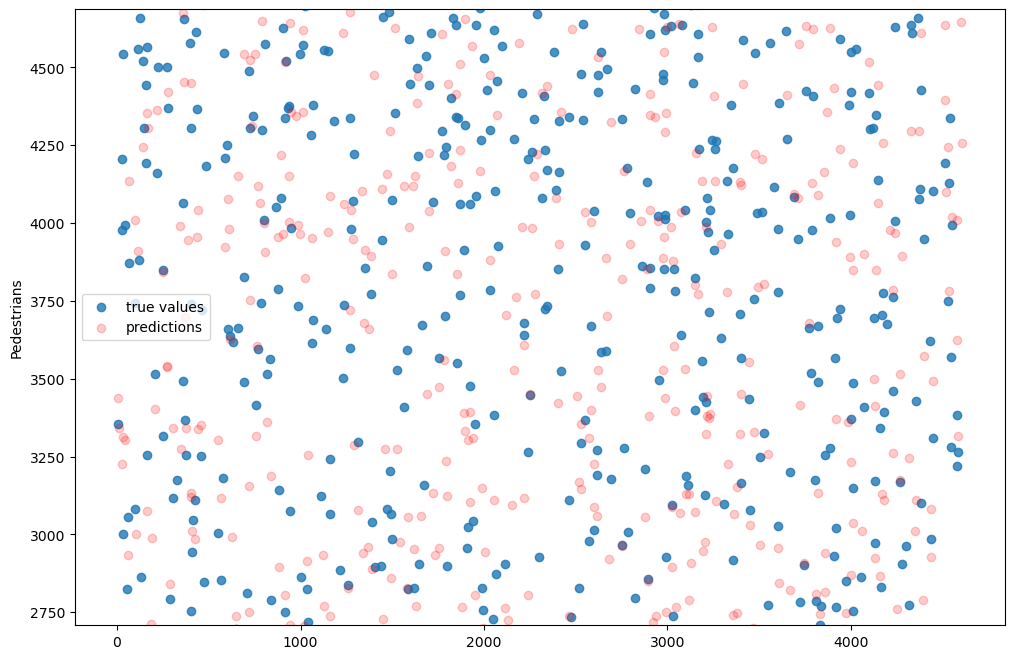

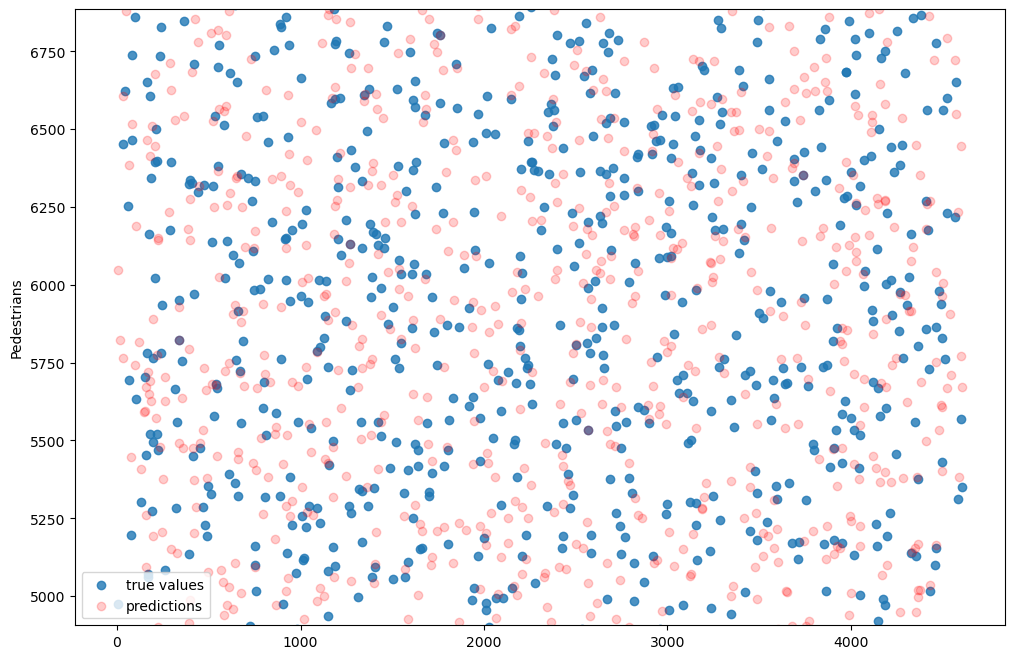

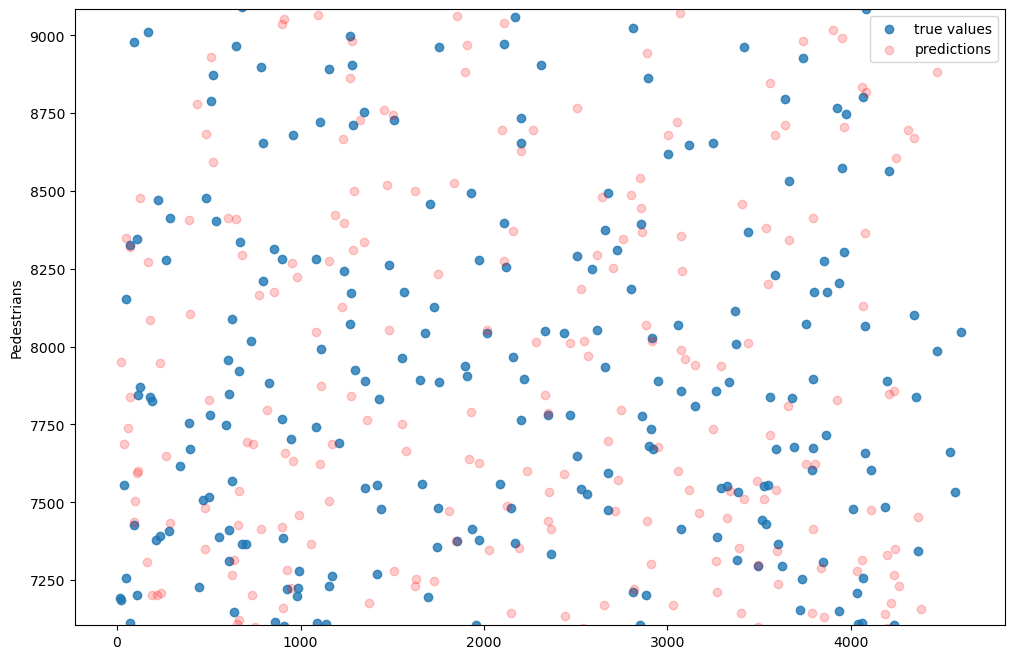

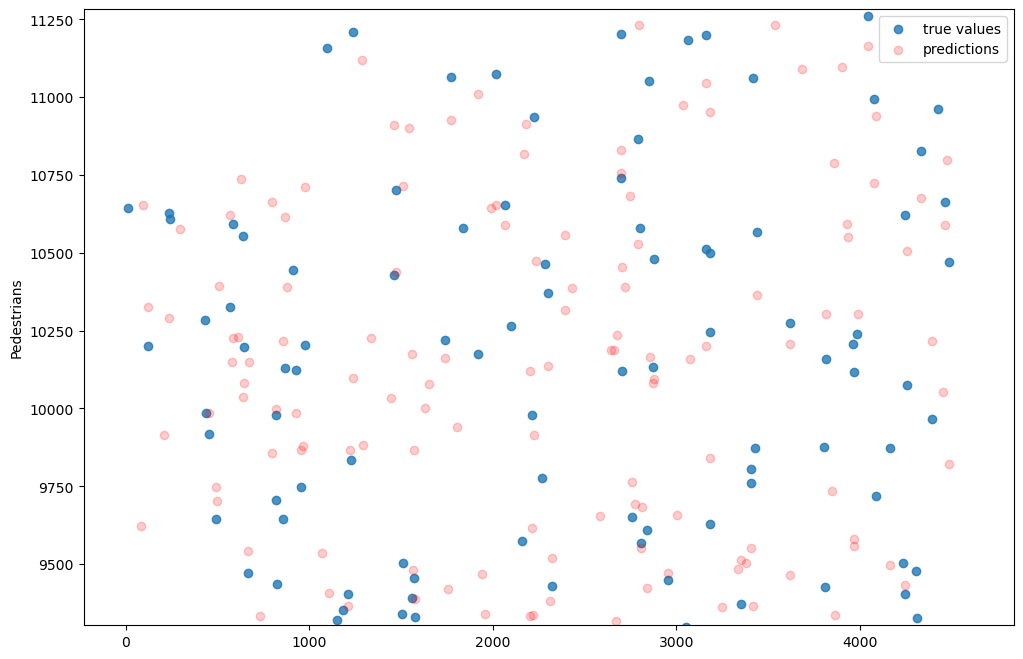

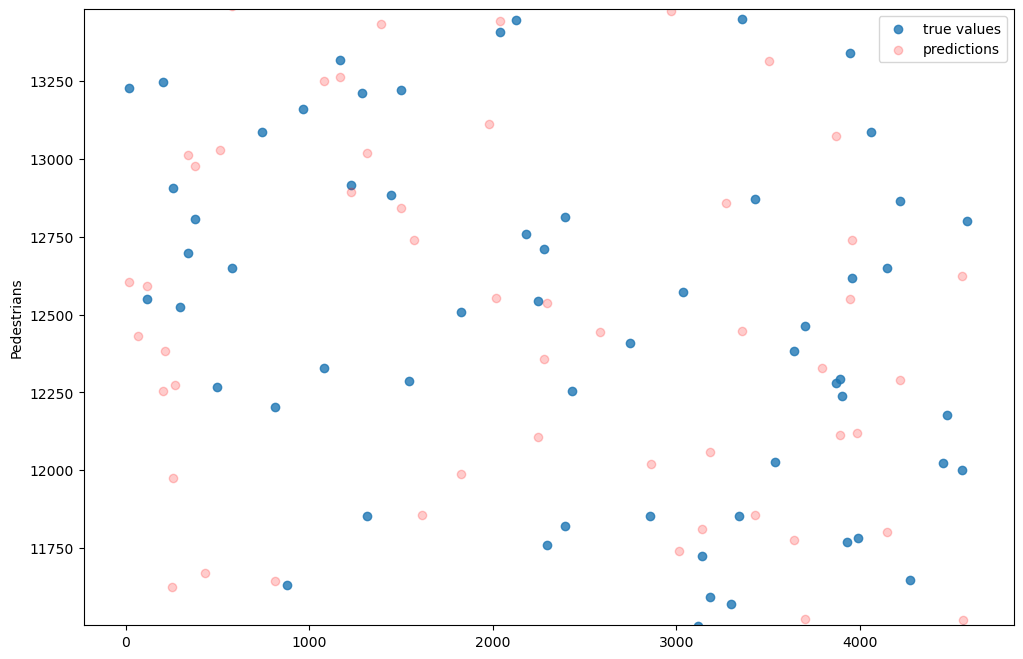

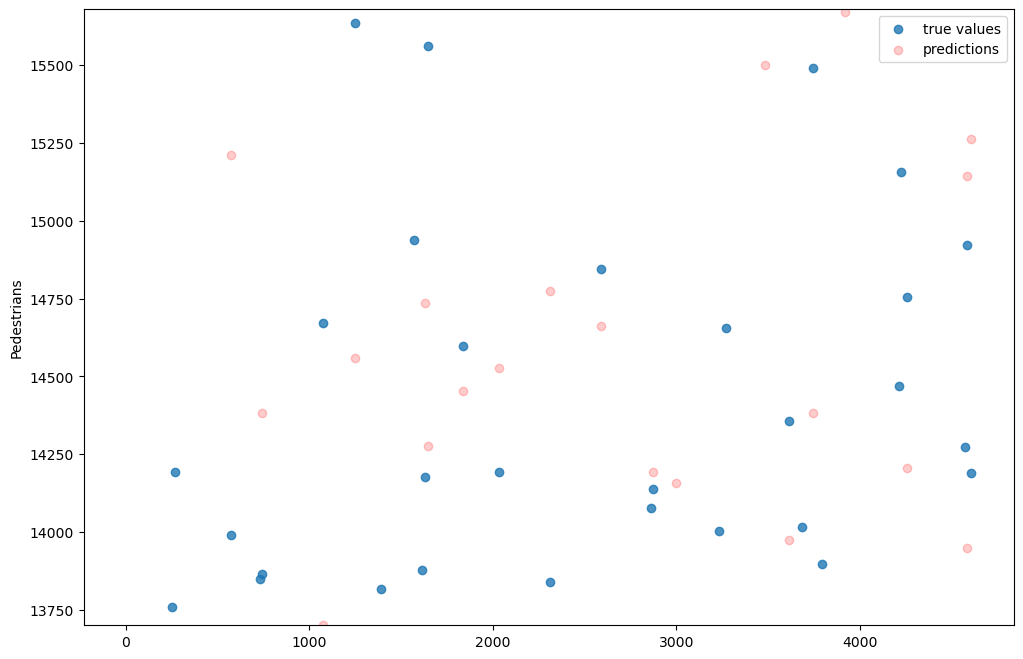

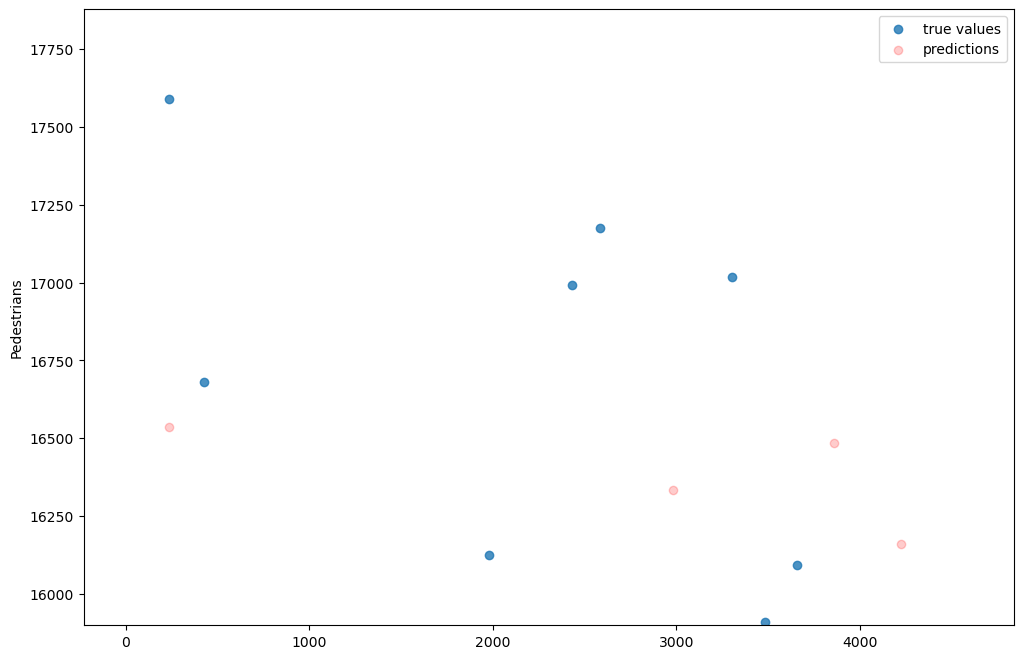

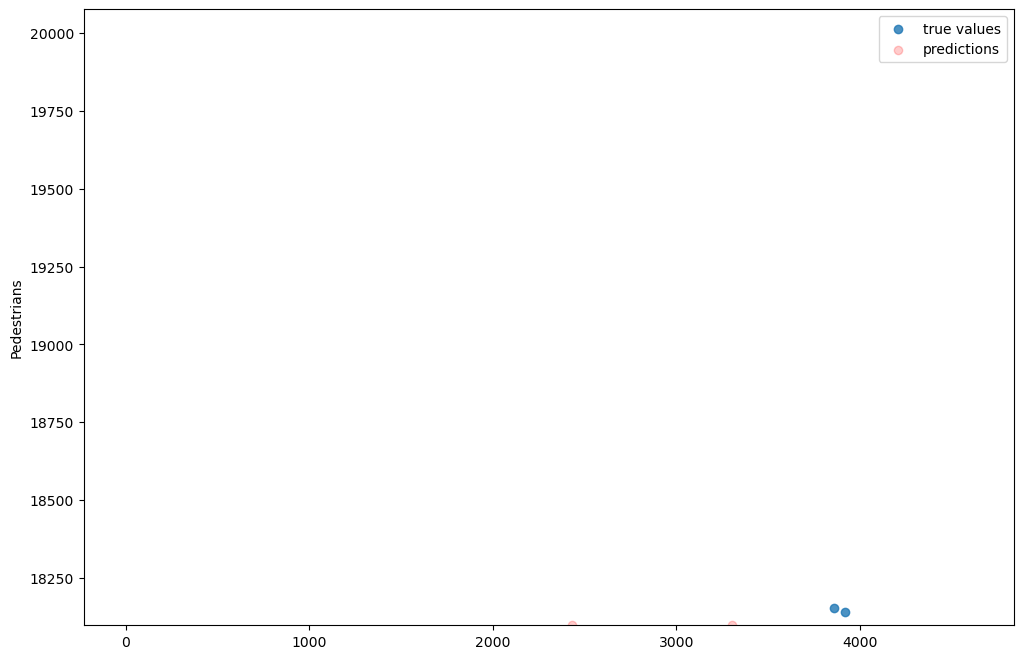

In [7]:
# plot the results in smaller samples so it is better to look at

for i in np.linspace(ypred.min(), ypred.max(), 10):
    fig, ax = plt.subplots(figsize=(12, 8))
    # plot the true values for 2 pca variables
    ax.scatter(xs, ytest, label="true values", alpha=0.8)

    # plot the predictions
    ax.scatter(xs, ypred, label="predictions", color = "red", alpha=0.2)

    # Add labels and legend
    ax.set_ylabel("Pedestrians")
    ax.legend()
    ax.set_ylim(ymin=i, ymax=i+((ypred.max()-ypred.min())/10))

In [68]:
# conduncting the parameter analysis on the most used parameter for optimization
# how many hidden layers with how many neurons are we going to use
hidden_layer_sizes = [(32, 64, 32), (64, 128, 64), (32, 64, 128, 64, 32)],
# activation function that is going to be used on the hidden layers
activation = ["relu", "logistic", "tanh", "identity"],
# the solver which optimizes the weights
solver = ["sgd", "adam"],
# regularization: avoids overfitting
alpha = [0.00005, 0.0001, 0.0005],
# number of samples that will be propagated through the network
batch_size = [16, 32, 64],
# how high is the initial learing rate
learing_rate_init = [0.001, 0.01],
# number of epochs
max_iter = [1000, 1500, 2000],

# create a dictionaire with all the used parameter
all_parameters_dict = {"hidden_layer_sizes":hidden_layer_sizes, "activation":activation, "solver":solver,
    "alpha":alpha, "batch_size":batch_size, "learning_rate_init":learing_rate_init, "max_iter":max_iter}

In [69]:
# scale the data to work so it is less sensitive to feature scaling 
scaler = StandardScaler()
# scale the inputs
scaler.fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
# apply the same transformation to the test data to have meaningful results
Xtest = scaler.transform(Xtest)
# scale the y different because we can't use standardscaler to a 1d array
mu, sigma = y.mean(), y.std() # We will use this to scale back to original values!
ytest = (ytest - mu) / sigma
ytrain = (ytrain - mu) /sigma

In [70]:
# Creating lists for all values given 
def list_appending(model):
   model.fit(Xtrain, ytrain)
   score_train.append(model.score(Xtrain, ytrain))
   score_test.append(model.score(Xtest, ytest))
   MAE_train.append(mean_absolute_error(ytrain, model.predict(Xtrain)))
   MAE_test.append(mean_absolute_error(ytest, model.predict(Xtest)))

score_train_total = []
score_test_total = []
MAE_train_total = []
MAE_test_total = []
print("start")

#Loop over list with all parameters
for parameter_n in list(all_parameters_dict.values()):
   #create a list for all scores for the different Models
   score_train = []
   score_test = []
   MAE_train = []
   MAE_test = []

   i=0

   #for parameter hidden_layer sizes
   if parameter_n == list(all_parameters_dict.values())[0]:
      print(i /len(list(all_parameters_dict.values())))
#go over all different hidden_layer_sizes
      for i in range(3):
         for param in list(all_parameters_dict.values())[0]:
         # change and fit the nnet
             nnet_changed = MLPRegressor(hidden_layer_sizes=param[i], max_iter=1000, random_state=72)
             list_appending(nnet_changed)

   #for parameter activation
   if parameter_n == list(all_parameters_dict.values())[1]:
      print(i /len(list(all_parameters_dict.values())))
#go over all different activation functions
      for i in range(4):
         for param in list(all_parameters_dict.values())[1]:
         # change and fit the nnet
             nnet_changed = MLPRegressor(activation=param[i], max_iter=1000, random_state=72)
             list_appending(nnet_changed)

   #for parameter solver
   if parameter_n == list(all_parameters_dict.values())[2]:
      print(i /len(list(all_parameters_dict.values())))
#go over all different solvers
      for i in range(2):
         for param in list(all_parameters_dict.values())[2]:
         # change and fit the nnet
             nnet_changed = MLPRegressor(solver=param[i], max_iter=1000, random_state=72)
             list_appending(nnet_changed)

   #for parameter alpha
   if parameter_n == list(all_parameters_dict.values())[3]:
      print(i /len(list(all_parameters_dict.values())))
#go over all different alphas
      for i in range(3):
         for param in list(all_parameters_dict.values())[3]:
         # change and fit the nnet
             nnet_changed = MLPRegressor(alpha=param[i], max_iter=1000, random_state=72)
             list_appending(nnet_changed)

   #for parameter batch_size
   if parameter_n == list(all_parameters_dict.values())[4]:
      print(i /len(list(all_parameters_dict.values())))
#go over all different batch_sizes
      for i in range(3):
         for param in list(all_parameters_dict.values())[4]:
         # change and fit the nnet
             nnet_changed = MLPRegressor(batch_size=param[i], max_iter=1000, random_state=72)
             list_appending(nnet_changed)

   #for parameter learning_rate_init
   if parameter_n == list(all_parameters_dict.values())[5]:
      print(i /len(list(all_parameters_dict.values())))
#go over all different initial learning rates
      for i in range(2):
         for param in list(all_parameters_dict.values())[5]:
         # change and fit the nnet
             nnet_changed = MLPRegressor(learning_rate_init=param[i], max_iter=1000, random_state=72)
             list_appending(nnet_changed)

   #for parameter max_iter
   if parameter_n == list(all_parameters_dict.values())[6]:
      print(i /len(list(all_parameters_dict.values())))
#go over all different epochs
      for i in range(3):
         for param in list(all_parameters_dict.values())[6]:
         # change and fit the nnet
             nnet_changed = MLPRegressor(max_iter=param[i], random_state=72)
             list_appending(nnet_changed)
###########################################################################################################
      print(i /len(list(all_parameters_dict.values())))
#add this scores to the total score list
      
   #After If
   score_train_total.append(score_train)
   score_test_total.append(score_test)
   MAE_train_total.append(MAE_train)
   MAE_test_total.append(MAE_test)

start
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.2857142857142857


In [72]:
#To save tha values for later
print(score_train_total,score_test_total,MAE_train_total,MAE_test_total)

[[-30838138175.457577, -43919876274.86508, -7298292409.398039], [-77483012425.37065, -853951969.5793681, -98770395517.93481, -4.533716272706089], [-749680733473.8301, -77483012425.37065], [-77592378098.11546, -77483012425.37065, -76910337676.32312], [-5781754669.630186, -11769840575.95904, -22939042996.440613], [-77483012425.37065, -10085395762.248005], [-77483012425.37065, -77483012425.37065, -77483012425.37065]] [[-47043239072.22383, -102437811742.20064, -9279588856.802195], [-137307107141.23296, -844793783.876037, -155495192531.6841, -4.662429950492542], [-774598179114.0005, -137307107141.23296], [-137366507703.39642, -137307107141.23296, -136581169730.98338], [-6091848278.916564, -21344323952.645744, -47246701970.90869], [-137307107141.23296, -18394726169.99286], [-137307107141.23296, -137307107141.23296, -137307107141.23296]] [[0.012772351558574967, 0.0150086332870829, 0.006301175304611983], [0.02024199633558367, 0.0021189918278112533, 0.022572614630353458, 1.82968632272275e-07], 

In [76]:
xval = np.array([i[0] for i in xval])
xval = xval.reshape(len(yval),1)


Text(0.5, 1.0, 'Standarized MAE for test and train data with different hidden_layer_sizes')

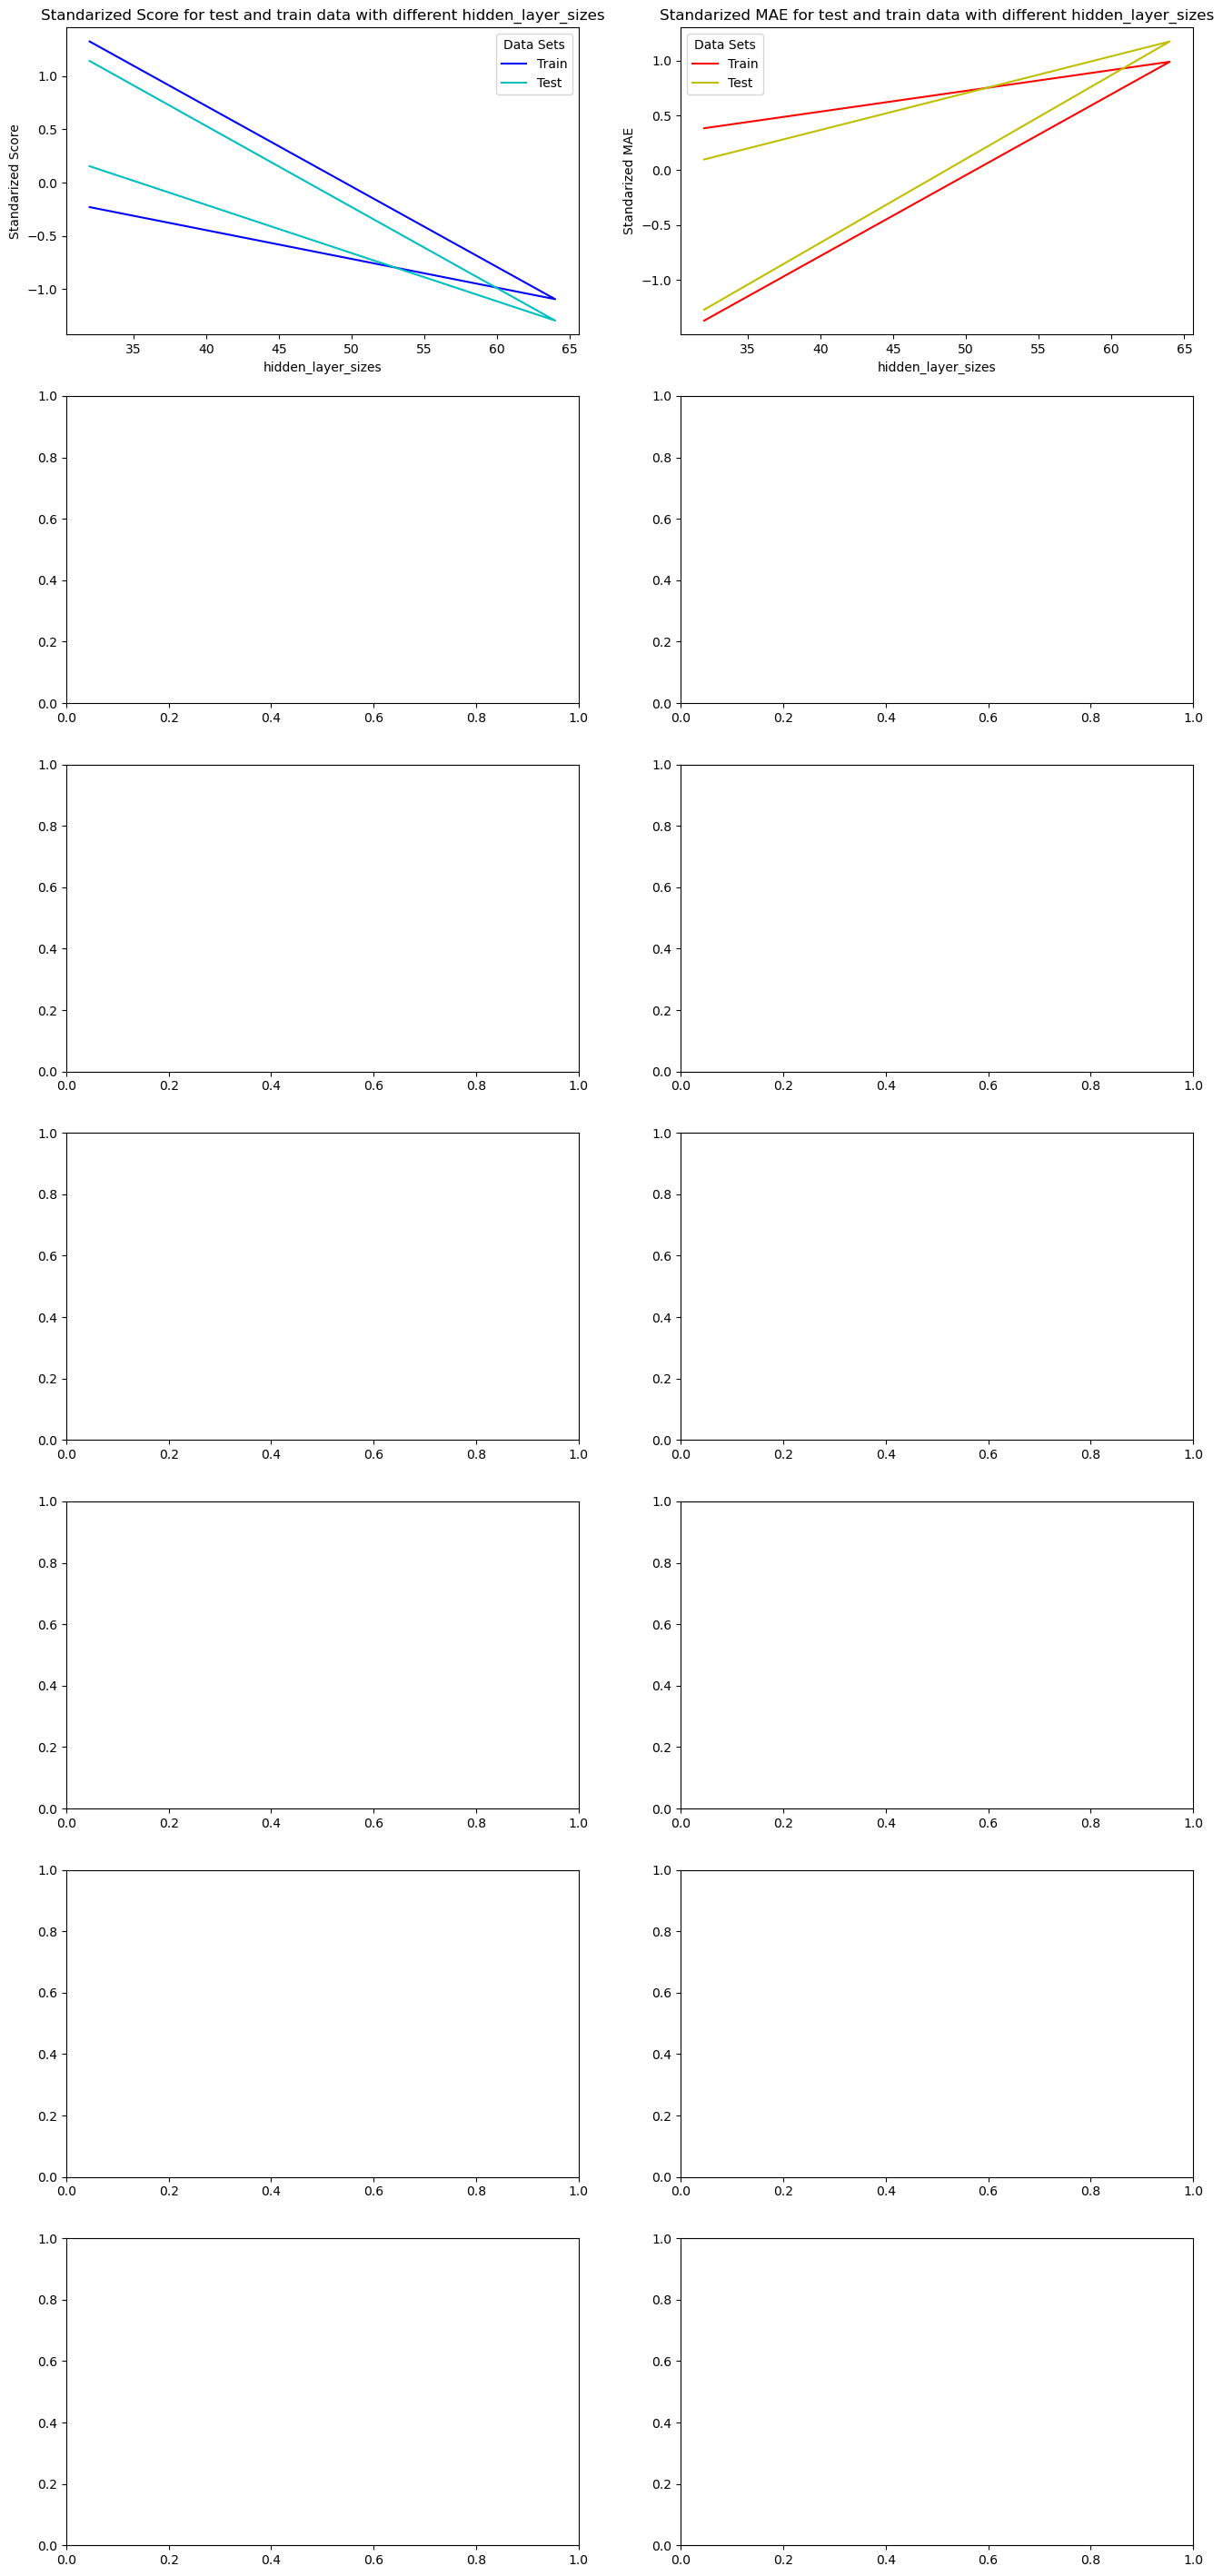

In [75]:
# visualize the results
standardize_list = lambda x,list: (x - (sum(list) / len(list))) / np.std(list)

# Create a figure and axis, specify the figure size
fig, axs = plt.subplots(len(score_train_total), 2, figsize=(16, 36))
    # Add the plot for MAE, standardized
axs[0][0].plot(xval, [standardize_list(i, score_train_total[0]) for i in score_train_total[0]],
                color="b", label="Train")
axs[0][0].plot(xval, [standardize_list(i, score_test_total[0]) for i in score_test_total[0]],
                color="c", label="Test")
    # Add the plot for score
axs[0][1].plot(xval, [standardize_list(i, MAE_train_total[0]) for i in MAE_train_total[0]], 
                color="r", label="Train")
axs[0][1].plot(xval, [standardize_list(i, MAE_test_total[0]) for i in MAE_test_total[0]], 
                 color="y", label="Test")
    # Add the legend
axs[0][0].legend(title="Data Sets")
axs[0][1].legend(title="Data Sets")

# Add the x- and y-axes labels
axs[0][0].set_xlabel(f"{list(all_parameters_dict.keys())[0]}")
axs[0][0].set_ylabel("Standarized Score")
axs[0][1].set_xlabel(f"{list(all_parameters_dict.keys())[0]}")
axs[0][1].set_ylabel("Standarized MAE")

# Add a title
axs[0][0].set_title(f"Standarized Score for test and train data with different {list(all_parameters_dict.keys())[0]}")
axs[0][1].set_title(f"Standarized MAE for test and train data with different {list(all_parameters_dict.keys())[0]}")

c:\Users\janag\miniconda3\envs\dsf\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: x and y must have same first dimension, but have shapes (1, 3) and (3,)

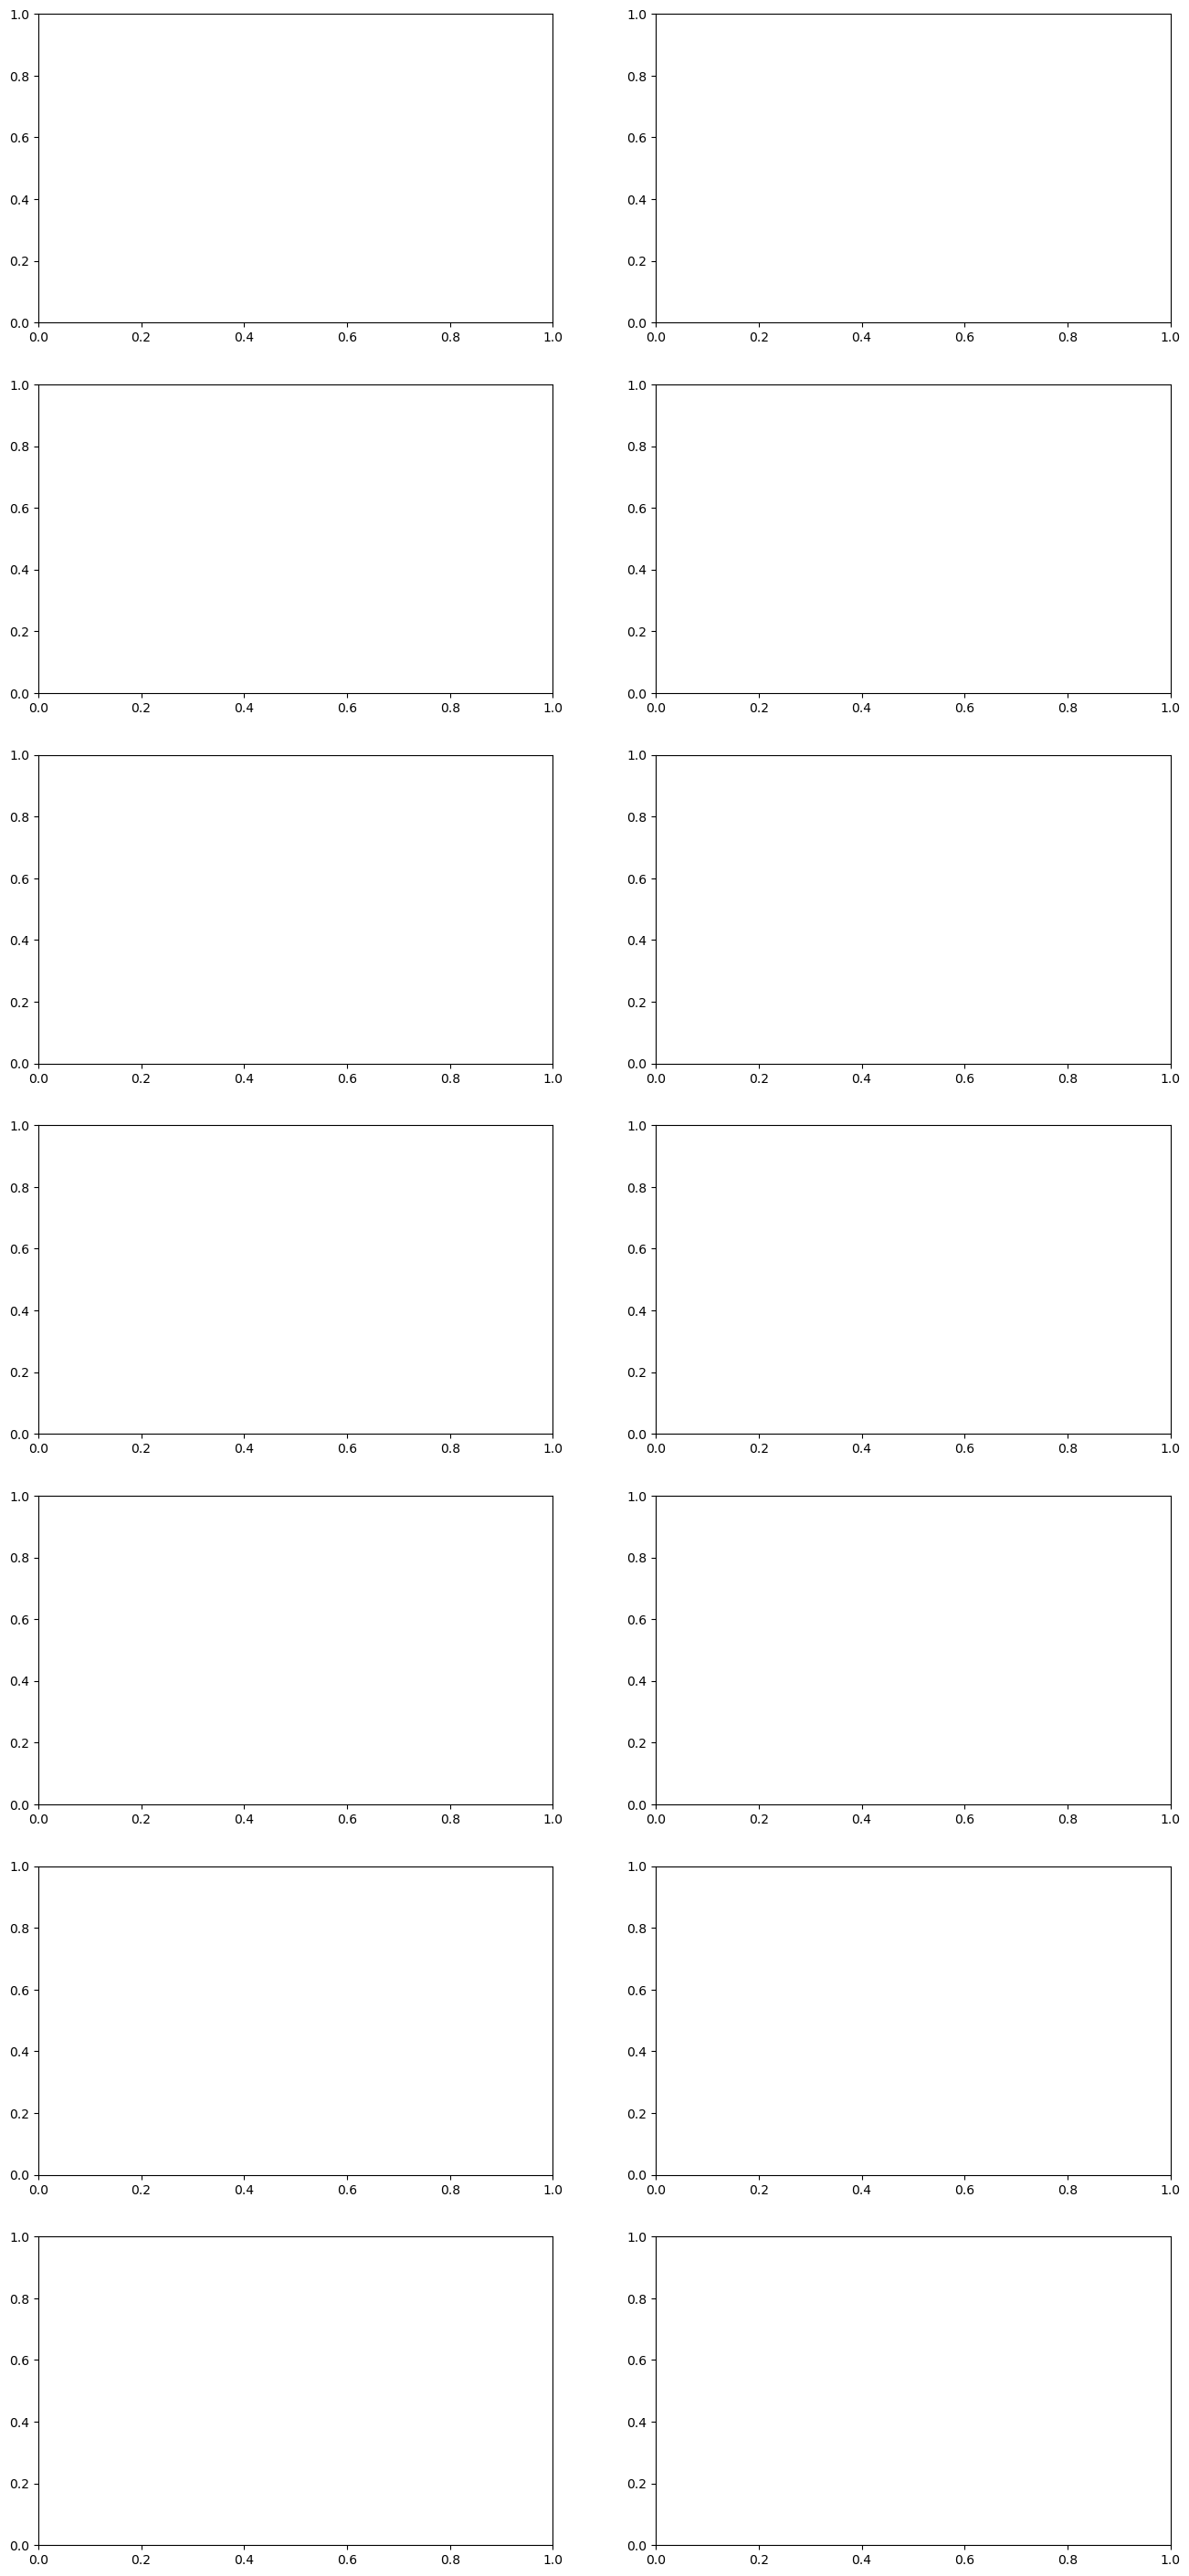

In [ ]:
# visualize the results
standardize_list = lambda x,list: (x - (sum(list) / len(list))) / np.std(list)

# Create a figure and axis, specify the figure size
fig, axs = plt.subplots(len(score_train_total), 2, figsize=(16, 36))#später 36

for n in range(len(score_train_total)):
    # Add the plot for MAE, standardized
    axs[n][0].plot(list(all_parameters_dict.values())[n], [standardize_list(i, score_train_total[n]) for i in score_train_total[n]],
                color="b", label="Train")
    axs[n][0].plot(list(all_parameters_dict.values())[n], [standardize_list(i, score_test_total[n]) for i in score_test_total[n]],
                color="c", label="Test")

    # Add the plot for score
    axs[n][1].plot(list(all_parameters_dict.values())[n], [standardize_list(i, MAE_train_total[n]) for i in MAE_train_total[n]], 
                color="r", label="Train")
    axs[n][1].plot(list(all_parameters_dict.values())[n], [standardize_list(i, MAE_test_total[n]) for i in MAE_test_total[n]], 
                 color="y", label="Test")
    # Add the legend
    axs[n][0].legend(title="Data Sets")
    axs[n][1].legend(title="Data Sets")

# Add the x- and y-axes labels
    axs[n][0].set_xlabel(f"{list(all_parameters_dict.keys())[n]}")
    axs[n][0].set_ylabel("Standarized Score")
    axs[n][1].set_xlabel(f"{list(all_parameters_dict.keys())[n]}")
    axs[n][1].set_ylabel("Standarized MAE")

# Add a title
    axs[n][0].set_title(f"Standarized Score for test and train data with different {list(all_parameters_dict.keys())[n]}")
    axs[n][1].set_title(f"Standarized MAE for test and train data with different {list(all_parameters_dict.keys())[n]}")

In [ ]:
# create figure from saved pictures
fig = plt.figure(figsize=(40, 40))
  
# setting values to rows and column variables
rows = 1
columns = 2
  
# reading images
img1 = Image.open("pictures/score_and_mae.png")
img2 = Image.open("pictures/score_and_mae2.png")
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(img1)
plt.axis('off')
plt.title("First")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(img2)
plt.axis('off')
plt.title("Second")

In [ ]:
img3 = Image.open("pictures/score_and_mae3.png")
img3

In [77]:
# scale the data so it is less sensitive to feature scaling
scaler = StandardScaler()
# scale the inputs
scaler.fit(X)
X = scaler.transform(X)

# scale the y different because we can't use standardscaler to a 1d array
mu, sigma = y.mean(), y.std() # We will use this to scale back to original values!
y = (y - mu) / sigma

scorers = ["r2", "neg_mean_absolute_error"]

parameters= {
    "hidden_layer_sizes": [(32, 64, 32), (64, 128, 64), (32, 64, 128, 64, 32)],
    "activation": ["tanh", "relu"],
    "solver": ["sgd", "adam"],
    "alpha": [0.0001, 0.0005, 0.00005],
    "learning_rate_init" : [0.001, 0.01],
    "max_iter" : [1000, 2000]
}

model1 = GridSearchCV(MLPRegressor(), parameters, cv=5, scoring=scorers, refit=False)
model1.fit(X, y)

results = pd.DataFrame()
params = model1.cv_results_["params"]

maes = model1.cv_results_["mean_test_neg_mean_absolute_error"]
r2s = model1.cv_results_["mean_test_r2"]

results["Params"] = pd.Series(params)
results["MeanMAE"] = pd.Series(maes)
results["MeanR2"] = pd.Series(r2s)

results.sort_values("MeanR2", inplace=True)

results.to_csv("results_nnet_gs.csv", sep=";", index=False)

results

,Params,MeanMAE,MeanR2
2,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",-0.472892,-0.211405
10,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",-0.448034,0.007808
36,"{'activation': 'tanh', 'alpha': 0.0005, 'hidde...",-0.430489,0.042200
62,"{'activation': 'tanh', 'alpha': 5e-05, 'hidden...",-0.408989,0.088827
14,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",-0.404322,0.089468
...,...,...,...
125,"{'activation': 'relu', 'alpha': 5e-05, 'hidden...",-0.169166,0.890692
85,"{'activation': 'relu', 'alpha': 0.0001, 'hidde...",-0.176035,0.891088
45,"{'activation': 'tanh', 'alpha': 0.0005, 'hidde...",-0.163545,0.891118
117,"{'activation': 'relu', 'alpha': 0.0005, 'hidde...",-0.154815,0.895262


In [91]:
# modelling the MLPRegressor with best parameters
# importing the data and splitting it to work with
# important!! use index_col=0 to read df otherwise pca starts at col 58
ped = pd.read_csv("data_clean_with_dummies.csv", index_col=0)

# beginning of the code, so everyone has the same
np.random.seed(1) # Set the random seed for reproduceability

# Define a new X with the squared feature k = 0.99, 57+46
X = np.array(ped[ped.columns[57:103]])

# Output to predict
y = ped["pedestrians count"]

# Split the dataset into train and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.3, random_state=72)

In [92]:
# initialize a neural network with the standard parameters 
nnet_optimization = MLPRegressor(hidden_layer_sizes=(32, 64, 32), activation="relu", solver="adam",
                    alpha=0.0001, learning_rate_init=0.01, max_iter=1000)

In [93]:
# scale the data to work so it is less sensitive to feature scaling 
scaler = StandardScaler()
# scale the inputs
scaler.fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
# apply the same transformation to the test data to have meaningful results
Xtest = scaler.transform(Xtest)
# scale the y different because we can't use standardscaler to a 1d array
mu, sigma = y.mean(), y.std() # We will use this to scale back to original values!
ytest = (ytest - mu) / sigma
ytrain = (ytrain - mu) /sigma

In [94]:
# Fit the network to the train data
nnet_optimization.fit(Xtrain, ytrain)

# Make predictions
ypred_train = nnet_optimization.predict(Xtrain)
ypred = nnet_optimization.predict(Xtest)

# Reconstruct outputs and scale predictions
ytest = ytest * sigma + mu
ytrain = ytrain * sigma + mu
ypred_train = ypred_train * sigma + mu
ypred = ypred * sigma + mu

# Compute the MAE
mae_train = mean_absolute_error(ytrain, ypred_train)
mae_test = mean_absolute_error(ytest, ypred)
# Comute R^2
r2_train = r2_score(ytrain, ypred_train)
r2_test = r2_score(ytest, ypred)

print(f"The mean absolute error of the training data is {mae_train:>10.2f}")
print(f"The R^2 of the training data is {r2_train:>10.2f}")
print(20 * "*")
print(f"The mean absolute error of the testing data is {mae_test:>10.2f}")
print(f"The R^2 of the testing data is {r2_test:>10.2f}")

The mean absolute error of the training data is     339.24
The R^2 of the training data is       0.96
********************
The mean absolute error of the testing data is     399.66
The R^2 of the testing data is       0.94


*Results:* <br> The mean absolute error of the training data is 339.24 <br>
The R^2 of the training data is 0.96 <br>
******************** <br>
The mean absolute error of the testing data is 400.66 <br>
The R^2 of the testing data is 0.94

In [95]:
# scale the data so it is less sensitive to feature scaling
scaler = StandardScaler()
# scale the inputs
scaler.fit(X)
X = scaler.transform(X)

# scale the y different because we can't use standardscaler to a 1d array
mu, sigma = y.mean(), y.std() # We will use this to scale back to original values!
y = (y - mu) / sigma

scorers = ["r2", "neg_mean_absolute_error"]

parameters= {
    "hidden_layer_sizes": [(32, 64, 32), (100,)],
    "activation": ["relu"],
    "solver": ["adam"],
    "alpha": [0.0001],
    "learning_rate_init" : [0.001],
    "batch_size" : [16, 32, 64],
    "max_iter" : [1000]
}

model1 = GridSearchCV(MLPRegressor(), parameters, cv=5, scoring=scorers, refit=False)
model1.fit(X, y)

results = pd.DataFrame()
params = model1.cv_results_["params"]

maes = model1.cv_results_["mean_test_neg_mean_absolute_error"]
r2s = model1.cv_results_["mean_test_r2"]

results["Params"] = pd.Series(params)
results["MeanMAE"] = pd.Series(maes)
results["MeanR2"] = pd.Series(r2s)

results.sort_values("MeanR2", inplace=True)

results.to_csv("results_nnet_gs2.csv", sep=";", index=False)

results

,Params,MeanMAE,MeanR2
1,"{'activation': 'relu', 'alpha': 0.0001, 'batch...",-0.340388,0.570843
5,"{'activation': 'relu', 'alpha': 0.0001, 'batch...",-0.338590,0.572783
3,"{'activation': 'relu', 'alpha': 0.0001, 'batch...",-0.282131,0.703913
4,"{'activation': 'relu', 'alpha': 0.0001, 'batch...",-0.199352,0.843564
0,"{'activation': 'relu', 'alpha': 0.0001, 'batch...",-0.186760,0.856872
2,"{'activation': 'relu', 'alpha': 0.0001, 'batch...",-0.182765,0.867577
